<a href="https://colab.research.google.com/github/Sarya-Mariam/Oil-Spill-Detection-System/blob/main/Oil_Spill_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/oil_spill_dataset

label_colors.txt  test	train  val


In [ ]:
# Download dataset from Zenodo
!wget "https://zenodo.org/records/10555314/files/dataset.zip?download=1" -O oilspill.zip

# Unzip into /content/oil_spill_dataset
!unzip -q oilspill.zip -d /content/oil_spill_dataset

# Check extracted folders
!ls /content/oil_spill_dataset


--2025-08-23 13:31:03--  https://zenodo.org/records/10555314/files/dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1137552692 (1.1G) [application/octet-stream]
Saving to: ‘oilspill.zip’

oilspill.zip        100%[===================>]   1.06G  26.8MB/s    in 10m 46s 

2025-08-23 13:41:50 (1.68 MB/s) - ‘oilspill.zip’ saved [1137552692/1137552692]

label_colors.txt  test	train  val


In [ ]:
!ls /content/oil_spill_dataset/train/images | head -5

Oil (1000).jpg
Oil (1001).jpg
Oil (1002).jpg
Oil (1003).jpg
Oil (1004).jpg


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/oil_spill_dataset"


In [ ]:
!ls "$DATASET_PATH/train/images" | head -20


Oil (1000).jpg
Oil (1001).jpg
Oil (1002).jpg
Oil (1003).jpg
Oil (1004).jpg
Oil (1005).jpg
Oil (1006).jpg
Oil (1009).jpg
Oil (100).jpg
Oil (1010).jpg
Oil (1011).jpg
Oil (1012).jpg
Oil (1013).jpg
Oil (1015).jpg
Oil (1016).jpg
Oil (1017).jpg
Oil (1018).jpg
Oil (101).jpg
Oil (1020).jpg
Oil (1021).jpg


In [ ]:
color_map = []
class_names = []

with open(f"{DATASET_PATH}/label_colors.txt") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 4:   # class_name + R + G + B
            class_names.append(parts[3])        # take class name
            rgb = tuple(map(int, parts[0:3]))   # take only the 3 numbers
            color_map.append(rgb)

print("Classes:", class_names)
print("Color Map:", color_map)

Classes: ['background', 'oil', 'others', 'water']
Color Map: [(0, 0, 0), (255, 0, 124), (255, 204, 51), (51, 221, 255)]


In [ ]:
!ls "$DATASET_PATH/train/masks" | head -5

Oil (1000).png
Oil (1001).png
Oil (1002).png
Oil (1003).png
Oil (1004).png


In [ ]:
mask_path = f"{DATASET_PATH}/train/masks"
print(f"Mask path set to: {mask_path}")

Mask path set to: /content/drive/MyDrive/oil_spill_dataset/train/masks


Mask path set to: /content/drive/MyDrive/oil_spill_dataset/train/masks/Oil (1000).png


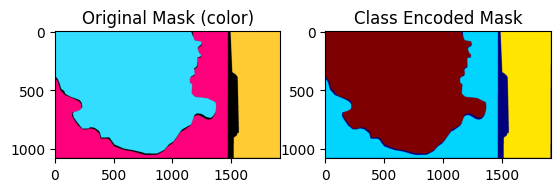

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATASET_PATH = "/content/drive/MyDrive/oil_spill_dataset"
mask_path = f"{DATASET_PATH}/train/masks/Oil (1000).png"
print(f"Mask path set to: {mask_path}")

mask_rgb = cv2.imread(mask_path)               # load mask
mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)

mask_class = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)

for idx, color in enumerate(color_map):
    mask_class[np.all(mask_rgb == color, axis=-1)] = idx

plt.subplot(1,2,1); plt.imshow(mask_rgb); plt.title("Original Mask (color)")
plt.subplot(1,2,2); plt.imshow(mask_class, cmap="jet"); plt.title("Class Encoded Mask")
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm   # progress bar

IMG_HEIGHT, IMG_WIDTH = 256, 256

def preprocess_dataset(image_dir, mask_dir, color_map):
    images = []
    masks = []

    # Loop over all files in the folder
    for file_name in tqdm(os.listdir(image_dir)):
        if file_name.endswith(".jpg"):
            img_path = os.path.join(image_dir, file_name)
            mask_path = os.path.join(mask_dir, file_name.replace(".jpg", ".png"))

            # --- Load image ---
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0   # normalize
            images.append(img)

            # --- Load mask ---
            mask_rgb = cv2.imread(mask_path)
            mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
            mask_rgb = cv2.resize(mask_rgb, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

            # Convert mask colors -> class indices
            mask_class = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
            for idx, color in enumerate(color_map):
                mask_class[np.all(mask_rgb == color, axis=-1)] = idx

            masks.append(mask_class)

    return np.array(images), np.array(masks)


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/oil_spill_dataset"

train_img_dir = f"{DATASET_PATH}/train/images"
train_mask_dir = f"{DATASET_PATH}/train/masks"

val_img_dir = f"{DATASET_PATH}/val/images"
val_mask_dir = f"{DATASET_PATH}/val/masks"

test_img_dir = f"{DATASET_PATH}/test/images"
test_mask_dir = f"{DATASET_PATH}/test/masks"

X_train, y_train = preprocess_dataset(train_img_dir, train_mask_dir, color_map)
X_val, y_val = preprocess_dataset(val_img_dir, val_mask_dir, color_map)
X_test, y_test = preprocess_dataset(test_img_dir, test_mask_dir, color_map)

print("Train set:", X_train.shape, y_train.shape)
print("Val set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


100%|██████████| 254/254 [01:46<00:00,  2.39it/s]


Train set: (811, 256, 256, 3) (811, 256, 256)
Val set: (203, 256, 256, 3) (203, 256, 256)
Test set: (254, 256, 256, 3) (254, 256, 256)


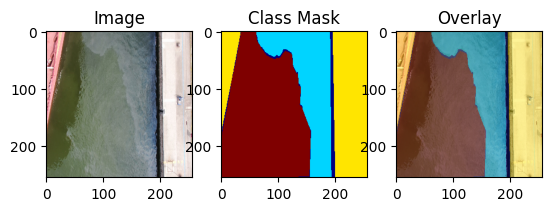

In [ ]:
import matplotlib.pyplot as plt

i = 10
plt.subplot(1,3,1); plt.imshow(X_train[i]); plt.title("Image")
plt.subplot(1,3,2); plt.imshow(y_train[i], cmap="jet"); plt.title("Class Mask")
plt.subplot(1,3,3); plt.imshow(X_train[i]); plt.imshow(y_train[i], alpha=0.4, cmap="jet"); plt.title("Overlay")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3), num_classes=len(color_map)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, 3, activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, 3, activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, 3, activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, 3, activation="relu", padding="same")(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
num_classes = len(color_map)

model = unet_model(num_classes=num_classes)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,940 (118.38 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install albumentations==1.4.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [ ]:
import albumentations as A

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
])


In [ ]:
import tensorflow as tf
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, augment=None, shuffle=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(images))
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_imgs, batch_masks = [], []

        for i in idxs:
            img, mask = self.images[i], self.masks[i]

            # ---- Augmentation fix ----
            if self.augment:
                # Convert to uint8 if normalized
                img_uint8 = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

                augmented = self.augment(image=img_uint8, mask=mask)
                img, mask = augmented['image'], augmented['mask']

                # Normalize back to [0,1] float32
                img = img.astype("float32") / 255.0

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path where you want to save the checkpoints
checkpoint_path = "/content/drive/MyDrive/oil_spill_dataset/checkpoints/unet_oil_spill.weights.h5"

# Create a ModelCheckpoint callback
# This will save the model's weights when the validation loss improves
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Now, include the callback in the model.fit() call
# I will modify the existing cell to add this callback

In [ ]:
batch_size = 8

train_gen = DataGenerator(X_train, y_train, batch_size=batch_size, augment=train_transform)
val_gen   = DataGenerator(X_val, y_val, batch_size=batch_size)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[model_checkpoint_callback] # Add the callback here
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/101 ━━━━━━━━━━━━━━━━━━━━ 1:01:05 37s/step - accuracy: 0.6893 - loss: 0.6567